# CS230 Fall 2024 Project Proposal: Transformer-based Surrogate Model for Subsurface Flow Simulation (Time Series Forecasting)
### Guido Di Federico, 0066465222
### Department of Energy Science and Engineering, Stanford University

### Load modules and packages

In [1]:
import os
import time
import random
import warnings
import shutil
import tempfile
import subprocess
from pathlib import Path
import time as timeModule

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import L1Loss
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, Callback
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data

from datasets import Dataset

### User functions

In [2]:
def create_random_dataframe(num_samples, params, seed_value=0):
    """
    Create a random DataFrame with specified ranges for different parameters.

    Parameters
    ----------
    num_samples: int
        The number of samples to generate.

    params: dict
        A dictionary with keys 'bhp_inj', 'k1', and 'f1', and value pairs 
        representing ranges for each parameter.

    seed_value: int, optional
        Random seed for reproducibility.

    Returns
    -------
    df: pd.DataFrame
        A DataFrame with randomly generated columns 'bhp_inj', 'k1', 'f1', 'k2', 
        'k3', 'f2', and 'f3' based on specified ranges and calculations.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)

    data = {
        'bhp_inj': np.round(np.random.uniform(params['bhp_inj'][0], params['bhp_inj'][1], num_samples)).astype(int),
        'k1': np.random.uniform(params['k1'][0], params['k1'][1], num_samples),
        'f1': np.random.uniform(params['f1'][0], params['f1'][1], num_samples),
    }
    
    df = pd.DataFrame(data)
    
    df['k2'] = df['k1'] * 10.0
    df['k3'] = df['k1'] * 50.0
    df['f2'] = df['f1'] * 1.5
    df['f3'] = df['f1'] * 2.0
    
    df[['k1', 'k2', 'k3']] = df[['k1', 'k2', 'k3']].round(0).astype(int)
    df[['f1', 'f2', 'f3']] = df[['f1', 'f2', 'f3']].round(2)
    
    return df


def model2tricat(model, thresh1, thresh2):
    """
    Categorize model values into three categories based on threshold values.

    Parameters
    ----------
    model: np.ndarray
        The model data array to categorize.

    thresh1: float
        The lower threshold for categorization.

    thresh2: float
        The upper threshold for categorization.

    Returns
    -------
    model_copy: np.ndarray
        The categorized model data, with values 0, 1, or 2 based on thresholds.
    """
    model_copy = np.copy(model)
    model_copy[model_copy < thresh1] = 0.
    model_copy[(model_copy >= thresh1) & (model_copy <= thresh2)] = 1.
    model_copy[model_copy > thresh2] = 2.
    
    return model_copy


def files_from_folder(folder, results_file):
    """
    List all files with the same name across subfolders in a given folder.

    Parameters
    ----------
    folder: str
        The main folder containing subfolders with the target files.

    results_file: str
        The name of the file present in each subfolder.

    Returns
    -------
    sorted_full_paths: list
        List of absolute paths to the specified files in each subfolder.
    """
    files = os.listdir(folder)
    sorted_files = sorted([os.path.join(folder, file_name) for file_name in files])
    
    idxs = [int(file.split('_')[-1]) for file in sorted_files]
    
    sorted_files_human = ["" for idx in range(len(sorted_files))]
    
    for i, idx in enumerate(idxs):
        sorted_files_human[idx] = sorted_files[i]
        
    sorted_full_paths = [file_name + results_file for file_name in sorted_files_human]

    return sorted_full_paths


def extract_sim_output(files, times, QoI):
    """
    Extract simulation outputs for specified times and quantities of interest (QoI).

    Parameters
    ----------
    files: list
        List of paths to the simulation results files.

    times: list
        List of times (in days) at which to extract simulation data.

    QoI: list
        List of strings representing the quantities of interest in the output files.

    Returns
    -------
    all_data: np.ndarray
        Extracted data array with shape (#files, #times, #QoI-1).
    """
    all_data = np.zeros((len(files), len(times), len(QoI)-1))

    for i in range(len(files)):
        path = files[i]
        output = pd.read_csv(path, index_col=False, delim_whitespace=True)
        
        selected_output = output[QoI]
        selected_output_times = abs(selected_output[selected_output['Day'].isin(times)].to_numpy()[:,1:])
    
        all_data[i] = selected_output_times
    
    return all_data


class SaveTrainValLossCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        if "train_loss" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_loss"].item()
            self.train_losses.append(train_loss)
            print(f"Epoch {trainer.current_epoch}: train_loss={train_loss}")

    def on_validation_epoch_end(self, trainer, pl_module):
        if "val_loss" in trainer.callback_metrics:
            val_loss = trainer.callback_metrics["val_loss"].item()
            self.val_losses.append(val_loss)
            print(f"Epoch {trainer.current_epoch}: val_loss={val_loss}")



### Set plotting parameters

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)           
plt.rc('axes', titlesize=BIGGER_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)     
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)     
plt.rc('figure', titlesize=BIGGER_SIZE)    

### Set additional parameters and directories

In [4]:
TOTAL_SIZE = 2816

In [5]:
device = torch.device("cuda")

In [6]:
torch.cuda.is_available()

True

In [7]:
results_dir   = './'
pics_dir      = './pics_cs230/'
sim_dir       = '/scratch/users/gdifede/adgprs_sims_cs230/'
dataset_path  = '/oak/stanford/schools/ees/lou/gdifede/cs230_project/dataset2'

if not os.path.exists(pics_dir):
    os.makedirs(pics_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Create dataset of simulation parameters

In [8]:
params = {
    'bhp_inj': (325, 355),
    'k1': (30, 50),
    'f1': (0.08, 0.12),
}

df_params_gen = create_random_dataframe(TOTAL_SIZE, params)
df_params_gen.to_csv(results_dir + 'params_dataset.csv', index=False) 

In [9]:
df_params = pd.read_csv(results_dir + 'params_dataset.csv')
df_params.head(10)

,bhp_inj,k1,f1,k2,k3,f2,f3
0,341,32,0.10,321,1605,0.15,0.20
1,346,38,0.11,379,1893,0.16,0.22
2,343,41,0.11,410,2052,0.16,0.21
3,341,32,0.10,325,1623,0.15,0.20
4,338,46,0.11,464,2318,0.16,0.21
5,344,40,0.08,399,1997,0.12,0.16
6,338,35,0.09,347,1734,0.14,0.18
7,352,42,0.09,419,2093,0.13,0.18
8,354,46,0.08,459,2293,0.12,0.17
9,337,37,0.09,366,1828,0.13,0.18


### Launch simulations with ADGPRS

In [10]:
#slurm_script_path = "/scratch/users/gdifede/adgprs_sims_cs230/launch.slurm"
#result = subprocess.run(["sbatch", slurm_script_path])

## Dataset and features

### Load dataset

In [11]:
loaded_dataset = Dataset.load_from_disk(dataset_path)
models = model2tricat(np.array([np.array(image) for image in loaded_dataset['image']])[:TOTAL_SIZE,:,:], 100, 200)*1. 
N_sim = models.shape[0]

In [12]:
sorted_full_paths        = files_from_folder(sim_dir +  'runs_update/', '/states_vars.rates.txt')[:N_sim]

dt                       = 50
dt_conversion            = 10
all_times                = list(np.arange(dt,1300,dt))
all_times_new            = list(np.arange(dt,1300,dt) / dt_conversion) 
end_of_hist_idx = 5
all_QoI                  = ['I1:WAT', 'I2:WAT',
                           'I3:WAT', 'I4:WAT',
                           'P1:WAT','P1:OIL']

all_geomodels            = models
all_QoI.insert(0,'Day') 


N_t                      = len(all_times)
N_QoI                    = len(all_QoI) - 1
dt_new                   = dt / dt_conversion


### Preprocess data

In [13]:
all_data_all_times_petrel = extract_sim_output(sorted_full_paths, all_times, all_QoI)
all_QoI = [item.replace('OIL', 'NAPL') for item in all_QoI]

all_times_array           = np.array(all_times*N_sim).reshape((N_sim,-1,1))
all_labels                = np.arange(N_sim)
labels_array              = np.repeat(all_labels, N_t).reshape((N_sim,-1,1)).astype(int)

In [14]:
color_dict = {}

for item in all_QoI:
    if 'NAPL' in item:
        color_dict[item] = 'green'
    elif 'P' in item and 'WAT' in item:
        color_dict[item] = 'steelblue'
    elif 'I' in item and 'WAT' in item:
        color_dict[item] = 'steelblue'

### Examples from the dataset

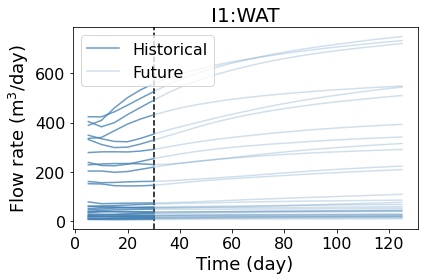

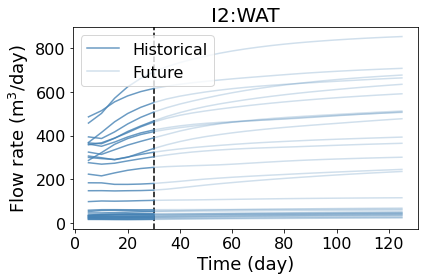

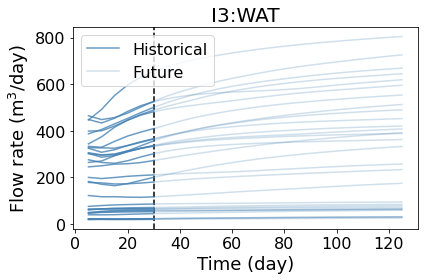

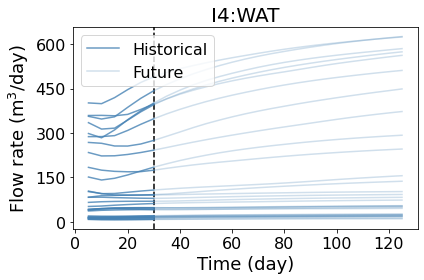

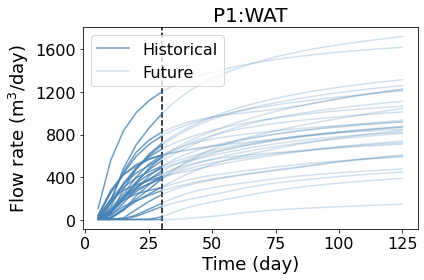

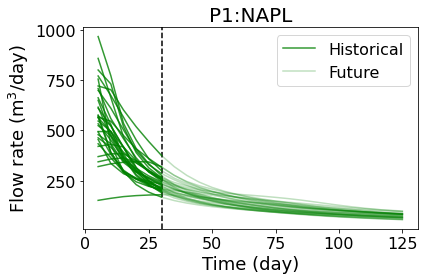

In [15]:
random_numbers = random.sample(range(N_sim), 30)

for QoI in all_QoI[1:]:
    QoI_idx = all_QoI.index(QoI) - 1
    plt.figure(QoI_idx)
    plt.axvline(x=dt_new * (end_of_hist_idx + 1), ymin=0, ymax=1, color='k', linestyle='--')

    for i in range(len(random_numbers)):
        run_idx = random_numbers[i]
        plt.plot(all_times_new[:end_of_hist_idx + 1], all_data_all_times_petrel[run_idx, :end_of_hist_idx + 1, QoI_idx], 
                 color=color_dict[QoI], alpha=0.8)
        plt.plot(all_times_new[end_of_hist_idx:], all_data_all_times_petrel[run_idx, end_of_hist_idx:, QoI_idx], 
                 color=color_dict[QoI], alpha=0.25)

    plt.plot(all_times_new[:end_of_hist_idx + 1], all_data_all_times_petrel[0, :end_of_hist_idx + 1, QoI_idx], 
             color=color_dict[QoI], alpha=0.8, label='Historical')
    plt.plot(all_times_new[end_of_hist_idx:], all_data_all_times_petrel[0, end_of_hist_idx:, QoI_idx], 
             color=color_dict[QoI], alpha=0.25, label='Future')

    plt.xlabel('Time (day)')
    plt.ylabel('Flow rate (m$^3$/day)')
    plt.legend(loc='best')
    plt.title(QoI)
    plt.tight_layout()

    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))


    plt.savefig(pics_dir + f'{QoI}_example.jpg', dpi=300)

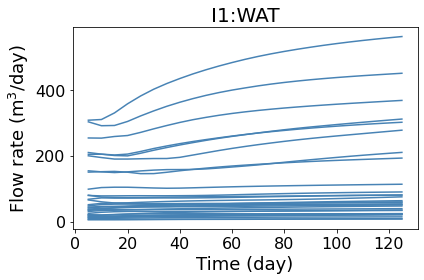

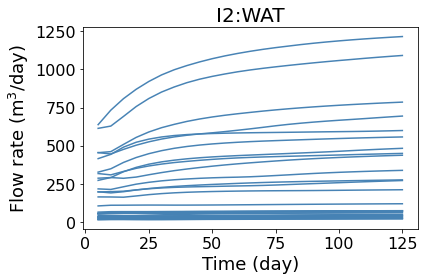

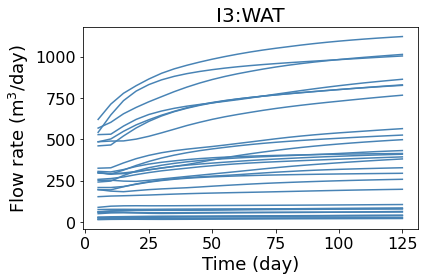

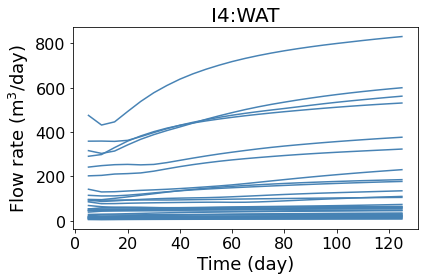

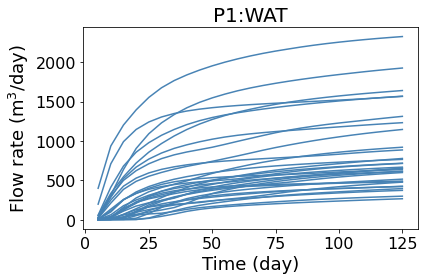

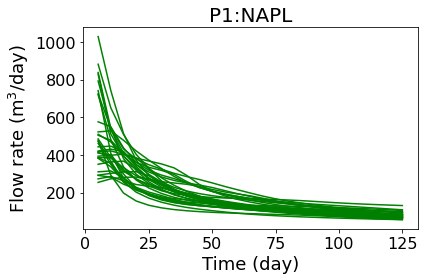

In [16]:
random_numbers = random.sample(range(N_sim), 30)

for QoI in all_QoI[1:]:
    QoI_idx = all_QoI.index(QoI) - 1
    plt.figure(QoI_idx)
    #plt.axvline(x=dt_new * (end_of_hist_idx + 1), ymin=0, ymax=1, color='k', linestyle='--')

    for i in range(len(random_numbers)):
        run_idx = random_numbers[i]
        plt.plot(all_times_new[:], all_data_all_times_petrel[run_idx, :, QoI_idx], 
                 color=color_dict[QoI], alpha=0.99)

    plt.plot(all_times_new[:], all_data_all_times_petrel[0, :, QoI_idx], 
             color=color_dict[QoI], alpha=0.99)

    plt.xlabel('Time (day)')
    plt.ylabel('Flow rate (m$^3$/day)')
    #plt.legend(loc='best')
    plt.title(QoI)
    plt.tight_layout()

    #plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))


    plt.savefig(pics_dir + f'{QoI}_example.jpg', dpi=300)

/tmp/ipykernel_70663/2822617731.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


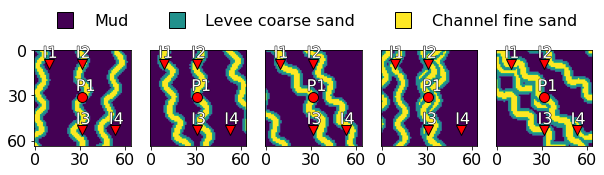

In [17]:
num_plots = 5
cols = 5

seed_value = 42
random.seed(seed_value)
random_numbers = random.sample(range(N_sim), num_plots)

well_locations = {
    'I1': (10, 10),
    'I2': (32, 10),
    'I3': (32, 54),
    'I4': (54, 54),
    'P1': (32, 32)
}
rows = (num_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows *3))

axes = axes.flatten()
random_indices = random.sample(range(models.shape[0]), num_plots)

for i, index in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(models[index], cmap='viridis')
    ax.set_xticks([0, 30, 60])

    
    if i == 0:
        ax.set_yticks([0, 30, 60])
    else:
        ax.set_yticks([])  # Hide y-ticks for other subplots
        ax.yaxis.set_visible(False)  # Optionally hide the entire y-axis

    for well, (x, y) in well_locations.items():
        x_adjusted = max(0, min(x - 5, models.shape[2] - 10))
        y_adjusted = max(0, min(y - 5, models.shape[1] - 10))
    
        txt = ax.text(x_adjusted, y_adjusted, well, color='white', fontsize=16)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='k')])

        ax.scatter(x-1, y-1, color='r', marker='o' if well[0] == 'P' else 'v', s=100, edgecolor = 'k')
        

norm = plt.Normalize(vmin=0, vmax=2)
cmap = plt.cm.viridis

colors = [cmap(norm(value)) for value in [0, 1, 2]]
labels = ['Mud', 'Levee coarse sand', 'Channel fine sand']
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markersize=16, markerfacecolor=color, label=label, markeredgecolor='k') for color, label in zip(colors, labels)]
plt.legend(handles=legend_handles, loc='center', frameon=False, bbox_to_anchor=(-1.9,1.3), fontsize=16, ncol=3)  
plt.tight_layout()
plt.savefig(pics_dir + f'models_seed{seed_value}_example.jpg', dpi = 300)

## Encoding 

In [18]:
encoding_type = 'pca'

### PCA

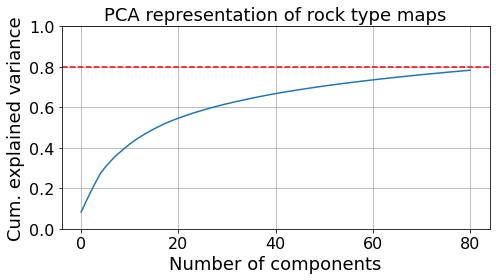

In [19]:
if encoding_type == 'pca':
    
    scaler = StandardScaler()
    all_geomodels = all_geomodels.reshape(N_sim, -1)  
    all_geomodels_standardized = scaler.fit_transform(all_geomodels)

    pca = PCA(n_components=81)  


    geomodels_pca          = pca.fit_transform(all_geomodels_standardized)
    geomodels_pca_flat     = np.repeat(geomodels_pca, N_t).reshape((geomodels_pca.shape[0], N_t, np.prod(geomodels_pca.shape[1:])))
    all_geomodels_flat     = geomodels_pca_flat
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(7, 4))
    plt.plot(cumulative_explained_variance)#, marker='o', markersize = 6)
    plt.title('PCA representation of rock type maps', fontsize = 18 )
    plt.xlabel('Number of components')
    plt.ylabel('Cum. explained variance')
    plt.grid()
    plt.axhline(y=0.80, color='r', linestyle='--')  # Threshold line at 95%
    plt.ylim([0,1])
    plt.tight_layout()
    plt.savefig(pics_dir + f'pca.jpg', dpi = 300)

else:
        pass
    

### Assemble all data

In [20]:
geo_labels                = [f"dim_{i}" for i in range(all_geomodels_flat.shape[-1])]

In [21]:
stacked_array      = np.concatenate((labels_array, all_times_array, all_data_all_times_petrel, all_geomodels_flat), axis=-1) 
flat_stacked_array = stacked_array.reshape((stacked_array.shape[0]*stacked_array.shape[1],stacked_array.shape[2]))
df_params_array    = df_params.loc[df_params.index.repeat(N_t)].reset_index(drop=True)

### Build dataset

In [22]:
data_rates = pd.DataFrame(flat_stacked_array)
data_rates.columns     = ['m'] + all_QoI + geo_labels


In [23]:
data_rates = pd.concat([data_rates, df_params_array], axis=1)

In [24]:
napl_columns = [col for col in data_rates.columns if 'NAPL' in str(col)]

data_rates['NAPL'] = data_rates[napl_columns].sum(axis=1)
data_rates        = data_rates.drop(columns=[col for col in napl_columns])

### Refine labels

In [25]:
data_rates['m']        = 'model_' + data_rates['m'].astype(str).str[:-2]

data_rates["time_idx"] = (data_rates["Day"] / dt ).astype(int)
data_rates["time_idx"] -= data_rates["time_idx"].min()

for i in range(all_geomodels_flat.shape[-1]):
    column_name = f'dim_{i}'
    data_rates[column_name] = data_rates[column_name].astype(float)

data_rates["Day"] = data_rates["Day"] / dt_conversion


In [26]:
data_rates

,m,Day,I1:WAT,I2:WAT,I3:WAT,I4:WAT,P1:WAT,dim_0,dim_1,dim_2,...,dim_80,bhp_inj,k1,f1,k2,k3,f2,f3,NAPL,time_idx
0,model_0,5.0,51.0697,31.5080,18.0146,359.1080,5.59197,12.208825,12.208825,12.208825,...,5.606553,341,32,0.10,321,1605,0.15,0.20,420.8530,0
1,model_0,10.0,55.1080,34.2650,19.0003,359.5410,5.92713,5.606553,5.606553,5.606553,...,-1.430088,341,32,0.10,321,1605,0.15,0.20,430.9260,1
2,model_0,15.0,56.1558,35.6499,18.7046,358.2050,18.60940,-1.430088,-1.430088,-1.430088,...,3.846094,341,32,0.10,321,1605,0.15,0.20,417.8440,2
3,model_0,20.0,55.0016,35.7928,18.4437,362.8850,95.73300,3.846094,3.846094,3.846094,...,0.374000,341,32,0.10,321,1605,0.15,0.20,349.6590,3
4,model_0,25.0,54.4341,36.2063,18.7039,379.5050,171.62100,0.374000,-1.400676,-1.400676,...,5.577711,341,32,0.10,321,1605,0.15,0.20,296.6570,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70395,model_2815,105.0,50.3145,349.5620,460.3270,12.5413,776.80100,-4.267187,-4.267187,-4.267187,...,-2.135737,335,34,0.11,340,1701,0.17,0.22,90.4612,20
70396,model_2815,110.0,50.7239,350.8160,463.2850,12.6169,783.09800,-2.135737,-2.135737,-2.135737,...,-1.247885,335,34,0.11,340,1701,0.17,0.22,88.9473,21
70397,model_2815,115.0,51.1331,351.9980,466.0750,12.6862,789.03700,-1.247885,-1.247885,-1.247885,...,-3.980772,335,34,0.11,340,1701,0.17,0.22,87.5388,22
70398,model_2815,120.0,51.5555,353.1680,468.7090,12.7543,794.75000,-3.980772,-3.980772,-3.980772,...,-1.021281,335,34,0.11,340,1701,0.17,0.22,86.1986,23


In [27]:
data_rates.to_csv(results_dir + 'data_rates.csv', index=False) 

## Build TimeSeriesDataset in PyTorch

In [28]:
max_prediction_length = 19
max_encoder_length    = end_of_hist_idx + 1
training_cutoff       = data_rates["time_idx"].max() - max_prediction_length

### Training set

In [29]:
training = TimeSeriesDataSet(
    data_rates[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="NAPL",
    group_ids=['m'],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals= list(df_params.columns) + geo_labels,
    time_varying_known_categoricals=[],
    variable_groups={}, 
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
         "I1:WAT", "I2:WAT", "I3:WAT", "I4:WAT", "P1:WAT", "NAPL" 
    ],
    target_normalizer=GroupNormalizer(
        groups=["m"], transformation="softplus"
    ), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


### Validation and testing set

In [30]:
validation = TimeSeriesDataSet.from_dataset(training, data_rates, predict=True, stop_randomization=True)
batch_size_baseline = TOTAL_SIZE
train_dataloader = training.to_dataloader(train=True, batch_size=TOTAL_SIZE)
val_dataloader = validation.to_dataloader(train=False, batch_size=TOTAL_SIZE)


### Baseline

In [31]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

/tmp/ipykernel_70663/2355500672.py:1: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/home/users/gdifede/.local/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/users/gdifede/.local/lib/python3.9

tensor(0.6256, device='cuda:0')

# Construct TFT model

## Training procedure

In [32]:
train_dataloader = training.to_dataloader(train=True, batch_size=32)
val_dataloader = validation.to_dataloader(train=True, batch_size=32)


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=100, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 
save_train_val_loss_callback = SaveTrainValLossCallback()

In [ ]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, save_train_val_loss_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    lstm_layers  = 2,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=16,
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    #reduce_on_plateau_patience=4,
) 
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:

start_time = timeModule.time()

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=train_dataloader,
)

print(f'Training took {(timeModule.time() - start_time) / 60. } mins.')

In [ ]:
all_train_loss = np.array(save_train_val_loss_callback.train_losses)
all_val_loss = np.array(save_train_val_loss_callback.val_losses)

In [ ]:
model_save_path = "tft_cs230.pth"
torch.save(tft.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

### Evaluate peformance

In [ ]:
best_tft = tft

In [ ]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size_baseline)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size_baseline)

In [ ]:
start_time = timeModule.time()
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cuda"))
print(f'Forecast took {timeModule.time() - start_time} seconds')

In [ ]:
tft_predictions = predictions.output.detach().cpu().numpy()
sim_true = predictions.y[0].detach().cpu().numpy()

In [ ]:
random_numbers = random.sample(range(N_sim), 4)

for i in range(len(random_numbers)):
    plt.figure(i)
    run_idx = random_numbers[i]
    
    bhp_inj = df_params.loc[run_idx, 'bhp_inj']
    k1 = df_params.loc[run_idx, 'k1']
    f1 = df_params.loc[run_idx, 'f1']

    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Adjust [3, 1] for desired width ratio

    ax1 = fig.add_subplot(gs[0])
    ax1.axvline(x=dt_new * (end_of_hist_idx + 1), ymin=0, ymax=1, color='k', linestyle='--')


    for QoI in all_QoI[1:]:
        QoI_idx = all_QoI.index(QoI) - 1
        ax1.axvline(x=dt_new * (end_of_hist_idx + 1), ymin=0, ymax=1, color='k', linestyle='--')
        ax1.plot(all_times_new[:end_of_hist_idx + 1], all_data_all_times_petrel[run_idx, :end_of_hist_idx + 1, QoI_idx], 
                     color=color_dict[QoI], alpha=0.8, label='Sim. hist. (water)')
        ax1.plot(all_times_new[end_of_hist_idx:], all_data_all_times_petrel[run_idx, end_of_hist_idx:, QoI_idx], 
                     color=color_dict[QoI], alpha=0.25, label='Sim. hist. (water)')

    if QoI == 'P1:NAPL':
        ax1.plot(all_times_new[end_of_hist_idx:], all_data_all_times_petrel[run_idx, end_of_hist_idx:, QoI_idx], 
                 color=color_dict[QoI], alpha=0.25, label='Sim. fut.(NAPL)')
        ax1.plot(all_times_new[:end_of_hist_idx + 1], all_data_all_times_petrel[run_idx,  :end_of_hist_idx + 1, QoI_idx], 
                 color=color_dict[QoI], alpha=0.8, label='Sim. hist. (NAPL)')
    
    ax1.scatter(all_times_new[end_of_hist_idx +1 :], tft_predictions[run_idx, :], 
             color='red', alpha=0.99, label='Surr. fut.(NAPL)')

    ax1.scatter(all_times_new[end_of_hist_idx], all_data_all_times_petrel[run_idx, end_of_hist_idx , QoI_idx], 
             color='red', alpha=0.99, label='Surr. fut.(NAPL)')

        
    
    handles, labels = ax1.get_legend_handles_labels()

    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)

    ax1.legend(unique_handles, unique_labels, fontsize = 14, loc = 'upper right')

    ax1.set_xlabel('Time (day)')
    ax1.set_ylabel('Flow rate (m$^3$/day)')

    ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax1.set_title(f'BHP$_{{inj}}$: {bhp_inj} bar, $k_{{low}}$:{k1} mD, $\\phi_{{low}}$: {f1:.2f}')
    #ax1.set_xticks(np.linspace(min(all_times_new), max(all_times_new), 6))
    

    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(models[run_idx], cmap='viridis', aspect='auto')  # Adjust cmap as necessary
    ax2.set_title('Rock type map')

    
    for well, (x, y) in well_locations.items():
        x_adjusted = max(0, min(x - 5, models.shape[2] - 10))
        y_adjusted = max(0, min(y - 5, models.shape[1] - 10))

        txt = ax2.text(x_adjusted, y_adjusted, well, color='white', fontsize=25)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='k')])

        ax2.scatter(x-1, y-1, color='r', marker='o' if well[0] == 'P' else 'v', s=100, edgecolor = 'k')

    plt.tight_layout()

    #plt.savefig(pics_dir + f'{QoI}_example_{run_idx}.jpg', dpi=300)
